In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from modules.utils import *
from modules.deg_analysis import *
from modules.visualize import *
from sklearn.model_selection import train_test_split
import torch
from modules.dataloader import PairedDataset
from torch.utils.data import DataLoader, DistributedSampler
import torch.optim as optim
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist
from modules.mlp_model import MLP, SiameseMLP
from modules.kan_model import DeepKAN, SiameseKAN
import torch.nn as nn
import scanpy as sc

2024-06-25 16:40:12.034352: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-25 16:40:12.597455: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# sample_tag_mapping = {'SampleTag17_flex':'WT-DMSO',
#                       'SampleTag18_flex':'3xTg-DMSO',
#                       'SampleTag19_flex':'WT-SCDi',
#                       'SampleTag20_flex':'3xTg-SCDi',
#                       'Undetermined':'Undetermined',
#                       'Multiplet':'Multiplet'}
# adata = anndata.read_h5ad("data/fede_count.h5ad")
# adata.obs['Sample_Tag'] = adata.obs['Sample_Tag'].map(sample_tag_mapping)
# anno_df = pd.read_csv("data/fede_mapping.csv", skiprows=4)

In [3]:
adata1 = anndata.read_h5ad("data/A_count.h5ad")
adata1.obs['Sample_Tag'] = 'LD_5xFAD'
adata2 = anndata.read_h5ad("data/B_count.h5ad")
adata2.obs['Sample_Tag'] = "LD_NC"
adata3 = anndata.read_h5ad("data/C_count.h5ad")
adata3.obs['Sample_Tag'] = "run_5xFAD"
adata4 = anndata.read_h5ad("data/D_count.h5ad")
adata4.obs['Sample_Tag'] = "run_NC"
adata = anndata.concat([adata1, adata2, adata3, adata4], axis=0)

anno_df1 = pd.read_csv("data/A_mapping.csv", skiprows=4)
anno_df2 = pd.read_csv("data/B_mapping.csv", skiprows=4)
anno_df3 = pd.read_csv("data/C_mapping.csv", skiprows=4)
anno_df4 = pd.read_csv("data/D_mapping.csv", skiprows=4)
anno_df = pd.concat([anno_df1, anno_df2, anno_df3, anno_df4])

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [4]:
adata = annotate_adata(adata, anno_df)

In [5]:
sc.pp.filter_cells(adata, min_genes=150)
sc.pp.filter_genes(adata, min_cells=3)
adata.var['mt'] = adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata.obs['high_mt'] = adata.obs['pct_counts_mt'] > 50
adata = adata[~adata.obs['high_mt'], :]
adata = adata[adata.obs['Sample_Tag'] != "Multiplet", :]
adata = adata[:, ~adata.var['mt']]

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [6]:
#sc.pp.normalize_total(adata)

In [7]:
unique_labels = {category: idx for idx, category in enumerate(adata.obs['Sample_Tag'].unique())}
adata.obs['target'] = adata.obs['Sample_Tag'].map(unique_labels)

/tmp/ipykernel_46877/1796125359.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['target'] = adata.obs['Sample_Tag'].map(unique_labels)
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [8]:
train_indices, test_indices = train_test_split(np.arange(adata.n_obs), test_size=0.2, random_state=42)
adata_train = adata[train_indices].copy()
adata_test = adata[test_indices].copy()

In [9]:
Y_train = np.array(adata_train.obs['target'].tolist())
Y_test = np.array(adata_test.obs['target'].tolist())
X_train = adata_train.X.toarray()
X_test = adata_test.X.toarray()

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = PairedDataset(X_train, Y_train, 5)
train_loader = DataLoader(train_dataset, batch_size=256, num_workers=8)

test_dataset = PairedDataset(X_test, Y_test, 5)
test_loader = DataLoader(test_dataset, batch_size=256, num_workers=8)

In [11]:
input_dim = X_train.shape[-1]
shared_layers = [4096,1024,256,32]
base_net = MLP(input_dim, shared_layers).to(device)
siamese_model = SiameseMLP(base_net).to(device)

In [12]:
optimizer = optim.RMSprop(siamese_model.parameters(), lr=0.0001)

In [13]:
epochs = 50
best_accuracy = 0
no_improvement_count = 0 

for epoch in range(epochs):
    train_loss = train_epoch(siamese_model, train_loader, optimizer, device, epoch)
    val_accuracy = eval_model(siamese_model, test_loader, device, epoch)
    print(f"Epoch {epoch}, Train Loss: {train_loss}, Validation Accuracy: {val_accuracy}")

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        no_improvement_count = 0  
        torch.save(siamese_model.base_network.state_dict(), 'best_model.pth')
        print("Model saved as best model")
    else:
        no_improvement_count += 1  

    if no_improvement_count >= 5:
        print("No improvement in validation accuracy for 5 consecutive epochs. Training stopped.")
        break

100%|███████████████████████████████████████| 1487/1487 [01:20<00:00, 18.50it/s]


Epoch 0, Train Loss: 0.2815495080213741, Validation Accuracy: 0.8067395646681659
Model saved as best model


100%|███████████████████████████████████████| 1487/1487 [01:20<00:00, 18.55it/s]


Epoch 1, Train Loss: 0.053058994921123474, Validation Accuracy: 0.8615708127368726
Model saved as best model


100%|███████████████████████████████████████| 1487/1487 [01:20<00:00, 18.50it/s]


Epoch 2, Train Loss: 0.024961459394917018, Validation Accuracy: 0.7698980128460534


100%|███████████████████████████████████████| 1487/1487 [01:20<00:00, 18.47it/s]


Epoch 3, Train Loss: 0.01701076165902151, Validation Accuracy: 0.8131006203193091


100%|███████████████████████████████████████| 1487/1487 [01:21<00:00, 18.35it/s]


Epoch 4, Train Loss: 0.014966832111319045, Validation Accuracy: 0.820712858734917


  1%|▍                                        | 16/1487 [00:03<05:20,  4.58it/s]


KeyboardInterrupt: 

In [14]:
input_dim = X_train.shape[-1]
shared_layers = [4096,1024,256,32]
base_net = MLP(input_dim, shared_layers)
model_path = 'best_model.pth'
checkpoint = torch.load(model_path, map_location=device)
base_net.load_state_dict(checkpoint)
base_net.to(device)

base_net.eval()
base_net.cpu()

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=29522, out_features=4096, bias=True)
    (1): Linear(in_features=4096, out_features=1024, bias=True)
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): Linear(in_features=256, out_features=32, bias=True)
  )
  (batchnorms): ModuleList(
    (0): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (activation): GELU(approximate='none')
  (dropout): Dropout(p=0.5, inplace=False)
)

In [15]:
data = torch.tensor(adata_test.X.toarray(), dtype=torch.float32)
latents = base_net(data)
latents_np = latents.detach().numpy()

In [16]:
adata_test.obsm['latents'] = latents_np

In [17]:
sc.pp.neighbors(adata_test, use_rep='latents')
sc.tl.leiden(adata_test, resolution=0.5)

/tmp/ipykernel_46877/3133289657.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_test, resolution=0.5)


In [18]:
sc.tl.umap(adata_test)

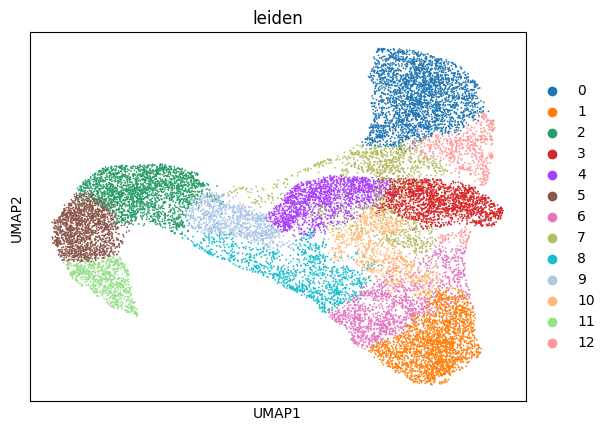

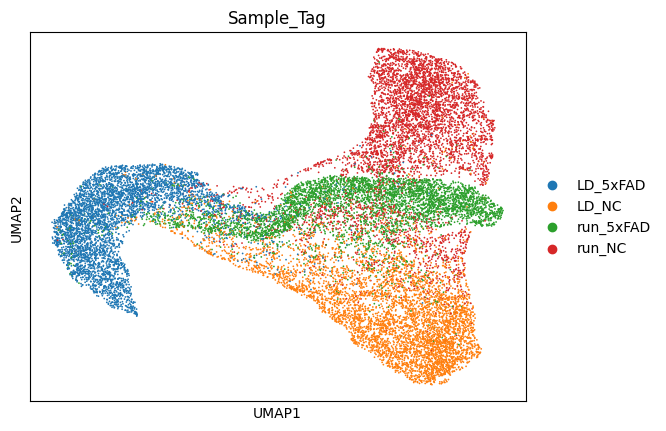

In [19]:
sc.pl.umap(adata_test, color=['leiden'], save='umap_leiden.png')
sc.pl.umap(adata_test, color=['Sample_Tag'], save='umap_sampletag.png')

In [20]:
assign_unique_cell_type_names(adata_test, cluster_key='leiden', cluster_types=['class_name', 'subclass_name'])

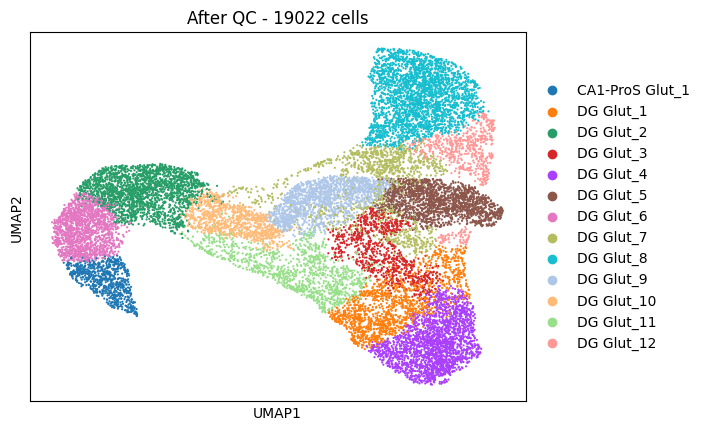

In [21]:
sc.pl.umap(adata_test, color=['cluster_subclass_name'], save='umap_all_groups.png', title=f'After QC - {adata_test.shape[0]} cells', size=10)

In [ ]:
#sc.pl.umap(adata_test, color=['Sample_Tag'], save='umap_all_groups.png', title=f'After QC - {adata_test.shape[0]} cells', size=10)

In [ ]:
#sample_tags = adata_test.obs['Sample_Tag'].unique()
#plot_umap(adata_test, cluster_type='cluster_subclass_name', legend_fontsize=7, save_path='_sample_tag')

In [ ]:
tags = adata_test.obs['Sample_Tag'].unique().tolist()

In [ ]:
class_level, cluster_type = 'subclass_name', 'cluster_subclass_name'

In [ ]:
create_ditto_plot(adata_test, tags, class_level=class_level, cluster_type=cluster_type, min_cell=100, save_path='figures/dito_siamese.png')
#create_ditto_plot(adata_test, [tags[0]], class_level=class_level, cluster_type=cluster_type, min_cell=100, save_path=None)
#create_ditto_plot(adata_test, [tags[1]], class_level=class_level, cluster_type=cluster_type, min_cell=100, save_path=None)
#create_ditto_plot(adata_test, [tags[2]], class_level=class_level, cluster_type=cluster_type, min_cell=100, save_path=None)
#create_ditto_plot(adata_test, [tags[3]], class_level=class_level, cluster_type=cluster_type, min_cell=100, save_path=None)